# <b>IMPORT LIBRARY</b>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from itertools import chain
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Load data
print("Loading data...")
train = pd.read_csv("/kaggle/input/final-exam-artificial-intelligence-2025-math-its/df_train.csv")
test = pd.read_csv("/kaggle/input/final-exam-artificial-intelligence-2025-math-its/df_test.csv")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Train columns: {train.columns.tolist()}")
print(f"Test columns: {test.columns.tolist()}")

Loading data...
Train shape: (9912, 6)
Test shape: (473, 2)
Train columns: ['prompt', 'essay', 'task_achievement', 'coherence_and_cohesion', 'lexical_resource', 'grammatical_range']
Test columns: ['prompt', 'essay']


# <b>HANDLE MISSING VALUE</b>

In [2]:
# Check for missing values
print("\nMissing values in train:")
print(train.isnull().sum())
print("\nMissing values in test:")
print(test.isnull().sum())

# Handle missing values in target columns
features = ['task_achievement', 'coherence_and_cohesion', 'lexical_resource', 'grammatical_range']
print(f"\nTarget features: {features}")

# Fill missing values with median for each target column
for feature in features:
    if train[feature].isnull().sum() > 0:
        median_val = train[feature].median()
        train[feature].fillna(median_val, inplace=True)
        print(f"Filled {train[feature].isnull().sum()} missing values in {feature} with median: {median_val}")


Missing values in train:
prompt                      0
essay                       0
task_achievement          245
coherence_and_cohesion    298
lexical_resource          674
grammatical_range         871
dtype: int64

Missing values in test:
prompt    0
essay     0
dtype: int64

Target features: ['task_achievement', 'coherence_and_cohesion', 'lexical_resource', 'grammatical_range']
Filled 0 missing values in task_achievement with median: 7.0
Filled 0 missing values in coherence_and_cohesion with median: 7.0
Filled 0 missing values in lexical_resource with median: 6.5
Filled 0 missing values in grammatical_range with median: 6.5


# <b>DATA VISUALIZATION</b>


Target shape: (9912, 4)
Target statistics:
       task_achievement  coherence_and_cohesion  lexical_resource  \
count       9912.000000             9912.000000       9912.000000   
mean           6.630952                6.687197          6.225736   
std            1.120075                1.350023          1.049052   
min            0.000000                0.000000          0.000000   
25%            6.500000                6.000000          6.000000   
50%            7.000000                7.000000          6.500000   
75%            7.000000                7.500000          7.000000   
max            9.000000                9.000000          8.000000   

       grammatical_range  
count        9912.000000  
mean            6.162934  
std             1.077061  
min             0.000000  
25%             6.000000  
50%             6.500000  
75%             7.000000  
max             8.500000  


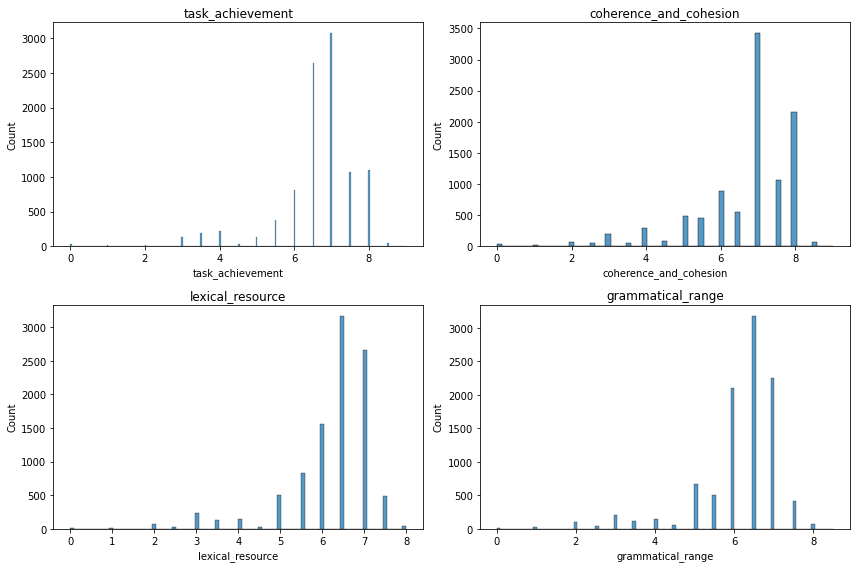

In [3]:
# Define target
target = train[features]
print(f"\nTarget shape: {target.shape}")
print("Target statistics:")
print(target.describe())

# Visualize target distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, feature in enumerate(features):
    sns.histplot(train[feature], ax=axes[i])
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

# <b>TEXT PRE-PROCESSING</b>

In [4]:
# Combine text data
text_train = train['essay'].fillna('')
text_test = test['essay'].fillna('')

# Combine all text for preprocessing
text = pd.concat([text_train, text_test], ignore_index=True)
print(f"\nCombined text shape: {text.shape}")

# Text preprocessing
print("Starting text preprocessing...")

# Convert to lowercase
text = text.str.lower()

# Remove special characters and numbers, keep only letters and spaces
text = text.apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# Remove extra whitespaces
text = text.apply(lambda x: re.sub(r'\s+', ' ', x).strip())

# Remove words less than 3 characters and greater than 15 characters
text = text.apply(lambda x: ' '.join([w for w in x.split() if len(w) >= 3 and len(w) <= 15]))

print("Text preprocessing completed.")

# Remove most frequent words (stop words alternative)
print("Removing most frequent words...")
all_words = ' '.join(text).split()
word_freq = pd.Series(all_words).value_counts()
most_freq_words = word_freq.head(30).index.tolist()
print(f"Most frequent words to remove: {most_freq_words[:10]}...")

text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in most_freq_words]))

# Remove rare words (appearing only once)
print("Removing rare words...")
v = text.str.split().tolist()
c = Counter(chain.from_iterable(v))
text = [' '.join([j for j in i if c[j] > 1]) for i in v]
text = pd.Series(text)

# Split back to train and test
X_text = text[:len(train)]
X_test_text = text[len(train):]

print(f"X_text shape: {X_text.shape}")
print(f"X_test_text shape: {X_test_text.shape}")


Combined text shape: (10385,)
Starting text preprocessing...
Text preprocessing completed.
Removing most frequent words...
Most frequent words to remove: ['the', 'and', 'that', 'for', 'their', 'are', 'this', 'people', 'they', 'can']...
Removing rare words...
X_text shape: (9912,)
X_test_text shape: (473,)


# <b>APPLY TF-IDF</b>

In [5]:
# Convert text to TF-IDF features
print("Converting text to TF-IDF features...")
vectorizer = TfidfVectorizer(
    max_features=9000,
    max_df=0.8,
    min_df=4,
    stop_words='english',
    ngram_range=(1, 2)
)

# Fit on training text and transform both train and test
X_tfidf = vectorizer.fit_transform(X_text)
X_test_tfidf = vectorizer.transform(X_test_text)

print(f"TF-IDF features shape - Train: {X_tfidf.shape}, Test: {X_test_tfidf.shape}")
print(f"Number of features: {len(vectorizer.get_feature_names_out())}")


Converting text to TF-IDF features...
TF-IDF features shape - Train: (9912, 9000), Test: (473, 9000)
Number of features: 9000


# <b>TRAINING MODEL</b>

In [6]:
# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_tfidf, target, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

# Train multi-output model
print("Training multi-output model...")

# Use RandomForestRegressor instead of SVR to avoid NaN issues
model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
)

# Fit the model
model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation RMSE: {np.sqrt(val_mse):.4f}")

# Individual feature MSE
for i, feature in enumerate(features):
    feature_mse = mean_squared_error(y_val.iloc[:, i], y_val_pred[:, i])
    print(f"{feature} - MSE: {feature_mse:.4f}, RMSE: {np.sqrt(feature_mse):.4f}")

Training set: (7929, 9000), (7929, 4)
Validation set: (1983, 9000), (1983, 4)
Training multi-output model...
Validation MSE: 1.2085
Validation RMSE: 1.0993
task_achievement - MSE: 1.0977, RMSE: 1.0477
coherence_and_cohesion - MSE: 1.6335, RMSE: 1.2781
lexical_resource - MSE: 1.0408, RMSE: 1.0202
grammatical_range - MSE: 1.0620, RMSE: 1.0305


# <b>TRAINING MODEL ON FULL DATA</b>

In [7]:
# Train final model on full training data
print("\nTraining final model on full training data...")
final_model = MultiOutputRegressor(
    RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
)

final_model.fit(X_tfidf, target)


Training final model on full training data...


MultiOutputRegressor(estimator=RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))

# <b>PREDICTIONS ON TEST DATA</b>

In [8]:
# Make predictions on test set
print("Making predictions on test set...")
test_predictions = final_model.predict(X_test_tfidf)

# Ensure predictions are within valid range (assuming scores are between 1-9)
test_predictions = np.clip(test_predictions, 1.0, 9.0)

print(f"Test predictions shape: {test_predictions.shape}")
print("Test predictions statistics:")
for i, feature in enumerate(features):
    pred_col = test_predictions[:, i]
    print(f"{feature}: min={pred_col.min():.2f}, max={pred_col.max():.2f}, mean={pred_col.mean():.2f}")

Making predictions on test set...
Test predictions shape: (473, 4)
Test predictions statistics:
task_achievement: min=1.85, max=8.06, mean=6.62
coherence_and_cohesion: min=1.22, max=8.02, mean=6.66
lexical_resource: min=1.55, max=7.56, mean=6.20
grammatical_range: min=1.22, max=7.35, mean=6.13


# <b>CREATE SUBMISSION FILE</b> 

Creating submission file...
Submission shape: (473, 5)
Submission sample:
   ID  task_achievement  coherence_and_cohesion  lexical_resource  \
0   1               6.1                     5.8               5.3   
1   2               2.8                     3.0               3.4   
2   3               5.7                     4.8               5.1   
3   4               6.0                     6.0               5.5   
4   5               7.0                     7.4               6.8   
5   6               5.8                     5.4               5.5   
6   7               5.8                     5.4               5.6   
7   8               7.0                     7.4               6.7   
8   9               5.5                     5.1               5.5   
9  10               6.0                     5.5               5.7   

   grammatical_range  
0                5.9  
1                6.1  
2                5.3  
3                5.5  
4                6.6  
5                5.3  
6    

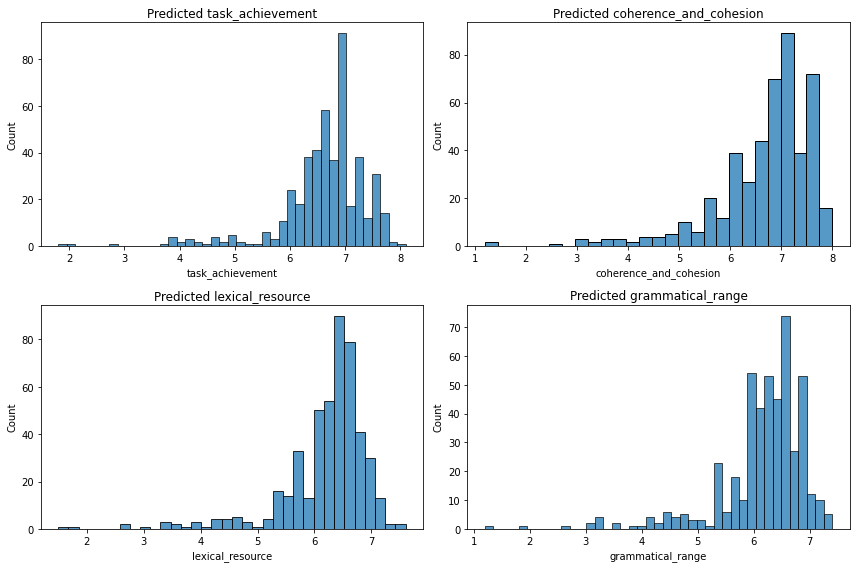

Process completed successfully!


In [9]:
# Create submission file
print("Creating submission file...")
submission = pd.DataFrame()
submission['ID'] = range(1, len(test) + 1)  # ID kolom mulai dari 1
submission['task_achievement'] = test_predictions[:, 0]
submission['coherence_and_cohesion'] = test_predictions[:, 1]
submission['lexical_resource'] = test_predictions[:, 2]
submission['grammatical_range'] = test_predictions[:, 3]

# Round predictions to 1 decimal place
for feature in features:
    submission[feature] = submission[feature].round(1)

print(f"Submission shape: {submission.shape}")
print("Submission sample:")
print(submission.head(10))

# Save submission
submission.to_csv('submission2.csv', index=False)
print("Submission saved as 'submission.csv'")

# Display submission statistics
print("\nSubmission statistics:")
print(submission[features].describe())

# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, feature in enumerate(features):
    sns.histplot(submission[feature], ax=axes[i])
    axes[i].set_title(f'Predicted {feature}')

plt.tight_layout()
plt.show()

print("Process completed successfully!")